In [102]:
import sys
import os
sys.path.append(os.path.abspath(".."))
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
from utils.libaries import *
from utils.data_loading import findFiles,LoadDataSignals
from utils.global_parameters import *
from Data_Denoising.data_denoising import *
from Data_Denoising.time_synchronization import *
from Data_Denoising.moving_average_filter import *
from Data_Denoising.derivative_filtering import apply_improved_derivative_filter
from Data_Denoising.dc_offset_removal import *
from plotting_module.signal_plot import *
from Data_Denoising.bandpass_filtering import *
from waveform_detection.detect_waveform import *
from waveform_detection.pan_algorithm import *
from time_of_flight_calculation.zero_crossings import *
from utils.libaries import *
from utils.data_loading import findFiles,LoadDataSignals
from utils.global_parameters import *
from Data_Denoising.data_denoising import *
from Data_Denoising.time_synchronization import *
from Data_Denoising.moving_average_filter import *
from Data_Denoising.derivative_filtering import apply_improved_derivative_filter
from Data_Denoising.dc_offset_removal import *
from plotting_module.signal_plot import *
from Data_Denoising.bandpass_filtering import *
from waveform_detection.detect_waveform import *
from waveform_detection.pan_algorithm import *
from time_of_flight_calculation.zero_crossings import *
from time_of_flight_calculation.tof import *
from time_of_flight_calculation.velocity import *
from time_of_flight_calculation.sugar_velocity_relationship import *
from time_of_flight_calculation.correlation import *
from plotting_module.crosscorrelation_plot import *


In [104]:
def findFiles(expected_waveforms, expected_periods, root_folder, sample_number=1):
    """
    Search and organize .mat files by waveform and burst (period) type.
    Returns a dictionary with keys as (waveform, burst_size) and values as lists of matching files.
    """
    from collections import defaultdict
    file_dict = defaultdict(list)

    for folder in os.listdir(root_folder):
        full_path = os.path.join(root_folder, folder)
        if not os.path.isdir(full_path):
            continue

        for filename in os.listdir(full_path):
            if not filename.endswith('.mat'):
                continue

            parts = filename.split('-')
            if len(parts) < 3:
                continue  # skip malformed names

            waveform_burst = parts[-2]  # e.g., 'squ5'
            if len(waveform_burst) < 4:
                continue

            waveform = waveform_burst[:3]
            burst = waveform_burst[3:4]
            sample = filename.split("_")[-1].split(".")[0]

            if waveform in expected_waveforms and burst in expected_periods and int(sample) == sample_number:
                file_dict[(waveform, burst)].append(os.path.join(full_path, filename))

    return file_dict


In [105]:
waveforms = ["sin", "squ"]
periods = ["1", "5", "9"]
root_folder = "/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/28_May_2025"

file_dict = findFiles(waveforms, periods, root_folder, sample_number=3)


In [106]:
file_dict

defaultdict(list,
            {('squ',
              '5'): ['/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/28_May_2025/144000mg/28thmaynewsetup1percentage25DegreeTemperatureMarch-ram-WaterSugar_mid_solution-144000mg-squ5-pure_water_solution_3.mat', '/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/28_May_2025/108000mg/28thmaynewsetup1percentage25DegreeTemperatureMarch-ram-WaterSugar_mid_solution-108000mg-squ5-pure_water_solution_3.mat', '/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/28_May_2025/36000mg/2025may28-ram-WaterSugar_mid_solution-36000mg-squ5-pure_water_solution_3.mat', '/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/28_May_2025/00000mg/2025may28-ram-WaterSugar_mid_solution-0mg-squ5-pure_water_solution_3.mat', '/Users/madhviasthana/Documents/Ex

In [107]:
def calculate_sugar_percentage(sugar_mg, water_quantity_ml):
    return (sugar_mg / water_quantity_ml) * 0.1


def convert_mg_to_percent(velocities, water_quantity_ml):
    converted_velocities = []
    for item in velocities:
        mg_value, velocity = item
        percent_value = calculate_sugar_percentage(mg_value, water_quantity_ml)
        converted_velocities.append([percent_value, velocity])
    return converted_velocities


def LoadDataSignals(file_path, time_axis_start=0, time_axis_end=16000):
    fs = 125000000
    actual_waveform = file_path.split("-")[-2]
    Concentration = file_path.split("-")[-3].strip("mg")
    periods = int(actual_waveform[-1])
    waveform = file_path.split("-")[-2][0:3]
    mat_data = loadmat(file_path)
    raw = np.squeeze(mat_data['raw_data'])
    return raw, Concentration, waveform, periods


def process_signals(unique_file_list, tof_method_index=1, comp_index=3):
    velocities, concentrations, tofs = [], [], []
    file_paths = []
    transmit_selected_index_list, receive_selected_index_list = [], []
    receive_selected_amplitude, transmit_selected_amplitude = [], []
    first_echo_start, first_echo_end = [], []
    refractometer_readings = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    selected_index_list = []

    tof_methods = ['peak_to_peak', 'zero_crossing', 'cross_correlation']
    selected_method = tof_methods[tof_method_index]
    print("Selected Method is: ", selected_method)

    start, end = 0, 16000

    for file in unique_file_list:
        print("\n\n File Name:", file)
        raw, concentration, actual_waveform, periods = LoadDataSignals(file)
        print("shape of raw signal: ", raw.shape)
        print("Period: ", periods)
        print("Concentration: ", concentration)

        transmit, receive = dc_offset_removal(raw)
        _transmit = transmit[0, start:end]
        _receive = receive[0, start:end]
        transmit_echo_list, recieve_echo_list, *_ = apply_pan_algorithm(
            _transmit, _receive, periods, T, low_cutoff, high_cutoff,
            order=4, window_size=11, min_prominence=0.05)

        t_start_index = transmit_echo_list[0][0]
        r_start_index = recieve_echo_list[0][0]

        if selected_method == 'zero_crossing':
            transmit_filtered = batch_apply_hanning_filter(transmit)
            receive_filtered = batch_apply_hanning_filter(receive)
            t_zero_pair = find_next_zero_crossings(transmit_filtered[0, :], [t_start_index])
            r_zero_pair = find_next_zero_crossings(receive_filtered[0, :], [r_start_index])
            tof = findTOF(t_zero_pair, r_zero_pair)

        elif selected_method == 'cross_correlation':
            band_tx = apply_bandpass_filter(transmit[0, start:end], fs, 3e6, 7e6)
            band_rx = apply_bandpass_filter(receive[0, start:end], fs, 3e6, 7e6)
            try:
                tof, delay_samples, corr, lags = calculate_windowed_tof_cross_correlation(
                    band_tx, band_rx, t_start_index, r_start_index - 100, fs=125e6, window_size=600)
                print("TOF calculated:", tof)
                plot_windowed_cross_correlation(corr, lags, tof)
            except Exception as e:
                print(f"[ERROR] Cross-correlation TOF calculation failed: {e}")
                continue

        velocity = find_Velocity(tof, distance=0.083)
        tofs.append(tof)
        velocities.append(velocity)
        concentrations.append(int(concentration))
        print("Velocity: ", velocity)

    zipped_data = list(zip(concentrations, velocities))
    converted_velocity = convert_mg_to_percent(zipped_data, water_quantity)
    time_of_flight = list(zip(concentrations, tofs))
    return converted_velocity, time_of_flight, actual_waveform, [], []


In [108]:
def process_burstwise_signals(unique_file_dict, waveform_filter='squ', tof_method_index=1):
    burst_results = {}

    for (waveform, period), file_list in unique_file_dict.items():
        if waveform != waveform_filter:
            continue  # Only process for specified waveform type

        print(f"\nProcessing Waveform: {waveform}, Burst Size: {period}")
        converted_velocity, _, _, _, _ = process_signals(file_list, tof_method_index=tof_method_index)
        burst_results[period] = converted_velocity

    return burst_results

# Visualization of Velocity vs Concentration for different burst sizes
def plot_burstwise_velocity(burst_results, waveform_label='Square Wave'):
    plt.figure(figsize=(10, 6))
    for burst_size, data in burst_results.items():
        data = sorted(data, key=lambda x: x[0])  # Sort by concentration
        concentrations = [item[0] for item in data]
        velocities = [item[1] for item in data]
        plt.plot(concentrations, velocities, marker='o', label=f'Burst Size {burst_size}')

    plt.xlabel("Sugar Concentration (%)")
    plt.ylabel("Velocity (m/s)")
    plt.title(f"Velocity vs Sugar Concentration for {waveform_label}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [109]:
burst_results=process_burstwise_signals(file_dict, waveform_filter='squ', tof_method_index=1)


Processing Waveform: squ, Burst Size: 5
Selected Method is:  zero_crossing


 File Name: /Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/28_May_2025/144000mg/28thmaynewsetup1percentage25DegreeTemperatureMarch-ram-WaterSugar_mid_solution-144000mg-squ5-pure_water_solution_3.mat
shape of raw signal:  (100, 2, 16000)
Period:  5
Concentration:  144000
DC Offset Removal - Transmit: (100, 16000)  | Receive: (100, 16000)
Dynamic Start Threshold: 0.5
Dynamic End Threshold: 0.2
Dynamic Start Threshold: 0.01
Dynamic End Threshold: 0.005
Transmit [(2, 116)]
Recieve [(6116, 8883)]
extrema_indices:  [2]
Signal at index 2: -291171.6875 (sign: -1.0)
Signal slice after index 2: [-276594.1875 -389190.9375 -509393.6875 -486317.1875 -468992.4375
 -497420.9375 -512226.1875]
extrema_index: 2 type: <class 'int'>
extrema_indices:  [6116]
Signal at index 2: 2750.0048828125 (sign: 1.0)
Signal slice after index 2: [ -72998.99316406 -124479.74414062 -2395

In [110]:
burst_results

{'5': [[8.470588235294118, 1698.1358139933538],
  [6.352941176470589, 1692.8990833670678],
  [2.1176470588235294, 1678.699672055353],
  [0.0, 1674.9436926451747],
  [1.0588235294117647, 1676.2495514803147],
  [3.1764705882352944, 1681.326935169593],
  [5.294117647058823, 1687.6698481904298],
  [4.235294117647059, 1684.766039653186],
  [7.411764705882354, 1695.7610772175274]],
 '1': [[8.470588235294118, 1698.1297242661303],
  [6.352941176470589, 1693.1005753319114],
  [2.1176470588235294, 1678.978673210041],
  [1.0588235294117647, 1676.6115201908194],
  [3.1764705882352944, 1681.4437575762051],
  [5.294117647058823, 1687.8808756405117],
  [4.235294117647059, 1684.7994512447024],
  [7.411764705882354, 1696.0168351176976]],
 '9': [[8.470588235294118, 1697.8656367016602],
  [6.352941176470589, 1692.6803958007408],
  [2.1176470588235294, 1678.6419030962347],
  [0.0, 1674.9576624869428],
  [1.0588235294117647, 1675.866964722963],
  [3.1764705882352944, 1681.2881217257377],
  [5.2941176470588

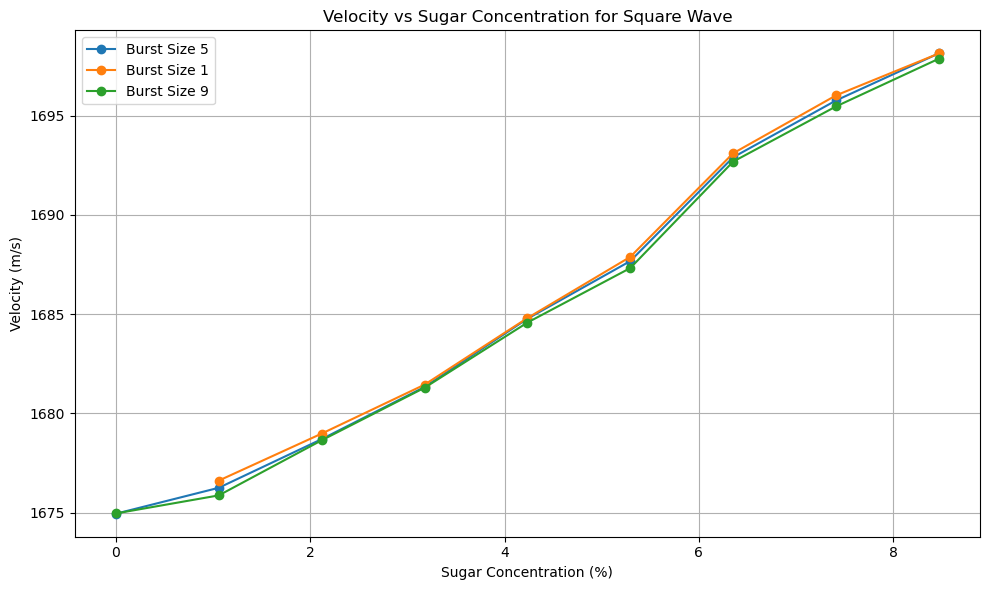

In [111]:
plot_burstwise_velocity(burst_results, waveform_label='Square Wave')

In [114]:

def plot_burstwise_velocity_with_refractometer(burst_results, waveform_label='Square Wave'):
    plt.figure(figsize=(12, 7))

    # Main plot: velocity vs concentration
    for burst_size, data in burst_results.items():
        data = sorted(data, key=lambda x: x[0])
        concentrations = [item[0] for item in data]
        velocities = [item[1] for item in data]
        plt.plot(concentrations, velocities, marker='o', label=f'Burst Size {burst_size}')

    # Refractometer reference: simple linear mapping to concentration
    all_concs = sorted(list({c for data in burst_results.values() for c, _ in data}))
    refractometer_readings = all_concs

    ax1 = plt.gca()
    ax2 = ax1.twinx()
    ax2.plot(all_concs, refractometer_readings, linestyle=':', marker='s', color='tab:red', alpha=0.3, label='Refractometer Reference')
    ax2.set_ylabel("Refractometer Reading", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    ax1.set_xlabel("Sugar Concentration (%)")
    ax1.set_ylabel("Velocity (m/s)", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_title(f"Velocity vs Sugar Concentration \n({waveform_label})")

    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    ax1.grid(True)
    plt.tight_layout()
    plt.show()



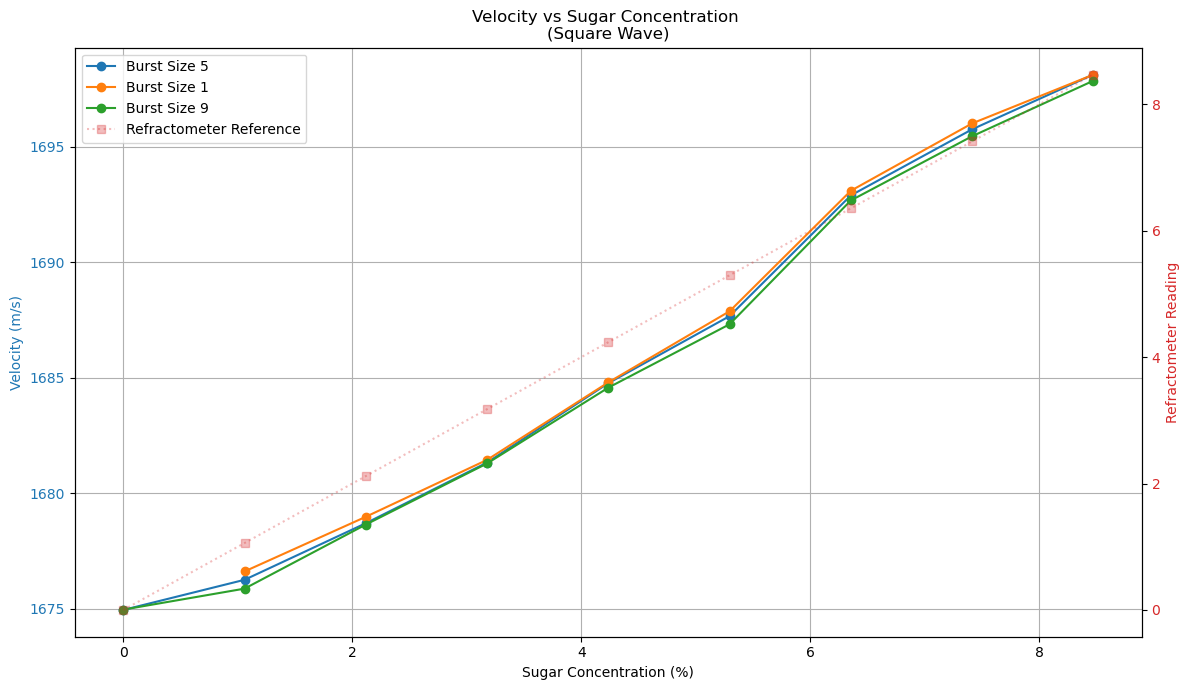

In [115]:
plot_burstwise_velocity_with_refractometer(burst_results)
